In [1]:
#runit
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score,f1_score,precision_score,confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
#runit
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Get the name of the current GPU
    current_gpu_name = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f"Current GPU: {current_gpu_name}")
else:
    print("CUDA is not available. Using CPU.")

torch.cuda.is_available()

Number of available GPUs: 1
Current GPU: NVIDIA GeForce MX150


True

In [3]:
#runit
#data=pd.read_csv('/kaggle/input/cic-ids-combined/final_dataset.csv')
data=pd.read_csv('final_dataset.csv')
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520793,53,32215,4,2,112,152,28,28,28.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2520794,53,324,2,2,84,362,42,42,42.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2520795,58030,82,2,1,31,6,31,0,15.5,21.92031,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2520796,53,1048635,6,2,192,256,32,32,32.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
import numpy as np

feature = np.array([8, 38, 13, 32, 1, 1, 1, 46, 11, 17, 16, 41, 2, 1, 6, 24, 30, 3, 1, 42, 33, 28, 34, 15,
                   27, 40, 44, 45, 43, 49, 54, 61, 59, 65, 18, 9, 36, 21, 39, 10, 7, 1, 1, 50, 56, 67, 25, 31,
                   52, 58, 68, 57, 1, 14, 1, 5, 66, 69, 60, 64, 62, 63, 22, 1, 29, 4, 19, 23, 12, 20, 47, 53])

indices_with_1 = np.where(feature == 1)[0]

print("Indices with a value of 1:", indices_with_1)


Indices with a value of 1: [ 4  5  6 13 18 41 42 52 54 63]


In [5]:
#runit
data=data.iloc[:,[4,5,6,13,18,41,42,52,54,63,78]]
# data = data.iloc[:,[6, 7, 8, 13, 18, 41, 42, 52, 54, 63,78]]
print(data)


         Total Length of Fwd Packets   Total Length of Bwd Packets  \
0                                 12                             0   
1                                  6                             6   
2                                  6                             6   
3                                  6                             6   
4                                 12                             0   
...                              ...                           ...   
2520793                          112                           152   
2520794                           84                           362   
2520795                           31                             6   
2520796                          192                           256   
2520797                          188                           226   

          Fwd Packet Length Max   Bwd Packet Length Std   Flow IAT Max  \
0                             6                     0.0              3   
1          

In [6]:
#runit
# Extract features and labels from the CSV file
features = data.drop(' Label', axis=1).values
labels = data[' Label'].values
print(labels)

['BENIGN' 'BENIGN' 'BENIGN' ... 'BENIGN' 'BENIGN' 'BENIGN']


In [7]:
#runit
# Label Encoding the labels, since PyTorch can not take strings as dtype
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(labels)
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'BENIGN': 0, 'Bot': 1, 'DDoS': 2, 'DoS GoldenEye': 3, 'DoS Hulk': 4, 'DoS Slowhttptest': 5, 'DoS slowloris': 6, 'FTP-Patator': 7, 'Heartbleed': 8, 'Infiltration': 9, 'PortScan': 10, 'SSH-Patator': 11, 'Web Attack � Brute Force': 12, 'Web Attack � Sql Injection': 13, 'Web Attack � XSS': 14}


In [8]:
# Define the MLP model without Batch Normalization
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1).to(torch.float64)
        self.bn1 = nn.BatchNorm1d(hidden_size1).to(torch.float64)  # Batch Normalization after the first hidden layer
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout after the first hidden layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2).to(torch.float64)
        self.bn2 = nn.BatchNorm1d(hidden_size2).to(torch.float64)  # Batch Normalization after the second hidden layer
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout after the second hidden layer
        self.fc3 = nn.Linear(hidden_size2, hidden_size3).to(torch.float64)
        self.bn3 = nn.BatchNorm1d(hidden_size3).to(torch.float64)  # Batch Normalization after the third hidden layer
        self.dropout3 = nn.Dropout(dropout_rate)  # Dropout after the third hidden layer
        self.fc4 = nn.Linear(hidden_size3, output_size).to(torch.float64)

    def forward(self, x):
        x = x.to(torch.float64)  # Convert input data to torch.float64
        x = self.dropout1(self.bn1(torch.relu(self.fc1(x))))  # Apply BatchNorm, Dropout, and ReLU
        x = self.dropout2(self.bn2(torch.relu(self.fc2(x))))  # Apply BatchNorm, Dropout, and ReLU
        x = self.dropout3(self.bn3(torch.relu(self.fc3(x))))  # Apply BatchNorm, Dropout, and ReLU
        x = self.fc4(x)
        return nn.functional.softmax(x, dim=1)


In [9]:

# Check if CUDA (GPU support) is available  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42, stratify=target_encoded)
X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [11]:
input_size = X_train.shape[1]  # Number of input features
hidden_size1 = 416  # Number of neurons in the first hidden layer
hidden_size2 = 320  # Number of neurons in the second hidden layer
hidden_size3 = 160  # Number of neurons in the third hidden layer
output_size = torch.unique(y_train_tensor).size(0)
print(input_size)
print(output_size)

10
15


In [12]:

# Create an instance of the MLP model and move it to the GPU
model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, output_size).to(device)


In [13]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

In [14]:

# Define loss function and optimizer weight=class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight = torch.DoubleTensor(class_weights).cuda())
optimizer = optim.Adam(model.parameters(), lr=0.00001)


In [15]:

# Number of training epochs and batch size
num_epochs = 50
batch_size = 128


In [16]:
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

In [17]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
train_accuracy = []
epochs_arr = []

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize variables to keep track of the best models
best_model_all_classes = None
best_model_highest_accuracy = None
best_accuracy_all_classes = 0.0
best_accuracy_highest_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_features, batch_labels in train_loader:
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluation on the test data
    model.eval()
    correct = 0
    total = 0
    test_predictions = []
    test_true_labels = []
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            test_predictions.extend(predicted.cpu().numpy())
            test_true_labels.extend(batch_labels.cpu().numpy())

    accuracy = correct / total

    train_accuracy.append(accuracy)
    epochs_arr.append(epoch + 1)

    precision = precision_score(test_true_labels, test_predictions, average='weighted')
    recall = recall_score(test_true_labels, test_predictions, average='weighted')
    f1 = f1_score(test_true_labels, test_predictions, average='weighted')

    print(f'Train Accuracy: {accuracy * 100:.2f}%')
    print(f'Train Precision: {precision:.4f}')
    print(f'Train Recall: {recall:.4f}')
    print(f'Train F1 Score: {f1:.4f}')

    # Save the model that has predictions for all classes
    unique_true_labels = set(test_true_labels)
    unique_predicted_classes = set(test_predictions)
    if unique_true_labels == unique_predicted_classes and accuracy > best_accuracy_all_classes:
        best_accuracy_all_classes = accuracy
        torch.save(model.state_dict(), 'best_model_all_classes.pth')

    # Save the model with the highest accuracy
    if accuracy > best_accuracy_highest_accuracy:
        best_accuracy_highest_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model_highest_accuracy.pth')

# At the end of training, 'best_model_all_classes.pth' will contain the state_dict of the best model
# with predictions for all classes, and 'best_model_highest_accuracy.pth' will contain the state_dict
# of the model with the highest accuracy overall.


Epoch [1/50], Loss: 2.4046


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 71.52%
Train Precision: 0.8688
Train Recall: 0.7152
Train F1 Score: 0.7605
Epoch [2/50], Loss: 1.8871


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 71.07%
Train Precision: 0.9122
Train Recall: 0.7107
Train F1 Score: 0.7862
Epoch [3/50], Loss: 2.0477


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 71.00%
Train Precision: 0.8700
Train Recall: 0.7100
Train F1 Score: 0.7620
Epoch [4/50], Loss: 2.0836


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 70.63%
Train Precision: 0.8761
Train Recall: 0.7063
Train F1 Score: 0.7591
Epoch [5/50], Loss: 2.4658


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 70.46%
Train Precision: 0.8662
Train Recall: 0.7046
Train F1 Score: 0.7592
Epoch [6/50], Loss: 1.8833


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 69.74%
Train Precision: 0.8738
Train Recall: 0.6974
Train F1 Score: 0.7530
Epoch [7/50], Loss: 1.9801


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 70.09%
Train Precision: 0.8726
Train Recall: 0.7009
Train F1 Score: 0.7551
Epoch [8/50], Loss: 2.7162


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 70.67%
Train Precision: 0.8766
Train Recall: 0.7067
Train F1 Score: 0.7606
Epoch [9/50], Loss: 2.2705


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 69.09%
Train Precision: 0.8711
Train Recall: 0.6909
Train F1 Score: 0.7474
Epoch [10/50], Loss: 2.2850


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 69.80%
Train Precision: 0.8723
Train Recall: 0.6980
Train F1 Score: 0.7527
Epoch [11/50], Loss: 2.0363


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 69.33%
Train Precision: 0.8744
Train Recall: 0.6933
Train F1 Score: 0.7512
Epoch [12/50], Loss: 1.9560


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 68.76%
Train Precision: 0.8730
Train Recall: 0.6876
Train F1 Score: 0.7469
Epoch [13/50], Loss: 2.0701


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 60.00%
Train Precision: 0.8651
Train Recall: 0.6000
Train F1 Score: 0.6844
Epoch [14/50], Loss: 1.9549


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 69.12%
Train Precision: 0.8727
Train Recall: 0.6912
Train F1 Score: 0.7489
Epoch [15/50], Loss: 2.2853


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 68.26%
Train Precision: 0.8726
Train Recall: 0.6826
Train F1 Score: 0.7431
Epoch [16/50], Loss: 1.9531


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 69.83%
Train Precision: 0.8726
Train Recall: 0.6983
Train F1 Score: 0.7540
Epoch [17/50], Loss: 2.1451


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 68.32%
Train Precision: 0.8742
Train Recall: 0.6832
Train F1 Score: 0.7446
Epoch [18/50], Loss: 2.3143


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 68.51%
Train Precision: 0.8734
Train Recall: 0.6851
Train F1 Score: 0.7445
Epoch [19/50], Loss: 1.9387


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 68.40%
Train Precision: 0.8734
Train Recall: 0.6840
Train F1 Score: 0.7448
Epoch [20/50], Loss: 2.0474


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 10.19%
Train Precision: 0.9232
Train Recall: 0.1019
Train F1 Score: 0.0820
Epoch [21/50], Loss: 2.0767


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 13.68%
Train Precision: 0.9278
Train Recall: 0.1368
Train F1 Score: 0.1510
Epoch [22/50], Loss: 2.2095


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 69.01%
Train Precision: 0.8739
Train Recall: 0.6901
Train F1 Score: 0.7493
Epoch [23/50], Loss: 1.8574


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 70.44%
Train Precision: 0.9201
Train Recall: 0.7044
Train F1 Score: 0.7857
Epoch [24/50], Loss: 2.3098


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 66.98%
Train Precision: 0.8687
Train Recall: 0.6698
Train F1 Score: 0.7328
Epoch [25/50], Loss: 2.0453


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 67.89%
Train Precision: 0.8704
Train Recall: 0.6789
Train F1 Score: 0.7396
Epoch [26/50], Loss: 2.4297


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 69.04%
Train Precision: 0.8713
Train Recall: 0.6904
Train F1 Score: 0.7476
Epoch [27/50], Loss: 2.1418


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 71.49%
Train Precision: 0.9207
Train Recall: 0.7149
Train F1 Score: 0.7930
Epoch [28/50], Loss: 1.8567


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 65.65%
Train Precision: 0.9115
Train Recall: 0.6565
Train F1 Score: 0.7457
Epoch [29/50], Loss: 2.4454


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 70.06%
Train Precision: 0.9197
Train Recall: 0.7006
Train F1 Score: 0.7821
Epoch [30/50], Loss: 1.9424


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 69.31%
Train Precision: 0.9187
Train Recall: 0.6931
Train F1 Score: 0.7759
Epoch [31/50], Loss: 2.3288


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 71.38%
Train Precision: 0.9199
Train Recall: 0.7138
Train F1 Score: 0.7911
Epoch [32/50], Loss: 1.9246


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 72.56%
Train Precision: 0.9220
Train Recall: 0.7256
Train F1 Score: 0.8002
Epoch [33/50], Loss: 2.0836


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 73.35%
Train Precision: 0.9236
Train Recall: 0.7335
Train F1 Score: 0.8073
Epoch [34/50], Loss: 1.9813


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 72.96%
Train Precision: 0.9236
Train Recall: 0.7296
Train F1 Score: 0.8044
Epoch [35/50], Loss: 1.9087


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 71.58%
Train Precision: 0.9220
Train Recall: 0.7158
Train F1 Score: 0.7935
Epoch [36/50], Loss: 2.6651


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 73.16%
Train Precision: 0.9222
Train Recall: 0.7316
Train F1 Score: 0.8041
Epoch [37/50], Loss: 2.1687


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 72.07%
Train Precision: 0.9230
Train Recall: 0.7207
Train F1 Score: 0.7979
Epoch [38/50], Loss: 2.5920


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 70.86%
Train Precision: 0.9221
Train Recall: 0.7086
Train F1 Score: 0.7892
Epoch [39/50], Loss: 2.0481


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 68.78%
Train Precision: 0.9198
Train Recall: 0.6878
Train F1 Score: 0.7738
Epoch [40/50], Loss: 2.4727


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 71.67%
Train Precision: 0.9238
Train Recall: 0.7167
Train F1 Score: 0.7962
Epoch [41/50], Loss: 2.5366


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 71.63%
Train Precision: 0.9237
Train Recall: 0.7163
Train F1 Score: 0.7950
Epoch [42/50], Loss: 2.4186


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 69.94%
Train Precision: 0.9219
Train Recall: 0.6994
Train F1 Score: 0.7830
Epoch [43/50], Loss: 2.4093


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 74.03%
Train Precision: 0.9239
Train Recall: 0.7403
Train F1 Score: 0.8115
Epoch [44/50], Loss: 2.5371


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 73.05%
Train Precision: 0.9222
Train Recall: 0.7305
Train F1 Score: 0.8039
Epoch [45/50], Loss: 2.4907


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 71.01%
Train Precision: 0.9254
Train Recall: 0.7101
Train F1 Score: 0.7852
Epoch [46/50], Loss: 2.0399


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 72.52%
Train Precision: 0.9240
Train Recall: 0.7252
Train F1 Score: 0.8023
Epoch [47/50], Loss: 2.2988


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 72.06%
Train Precision: 0.9262
Train Recall: 0.7206
Train F1 Score: 0.7999
Epoch [48/50], Loss: 2.3455


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 70.42%
Train Precision: 0.9246
Train Recall: 0.7042
Train F1 Score: 0.7811
Epoch [49/50], Loss: 1.9086


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 69.12%
Train Precision: 0.9228
Train Recall: 0.6912
Train F1 Score: 0.7732
Epoch [50/50], Loss: 2.2120


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 71.19%
Train Precision: 0.9242
Train Recall: 0.7119
Train F1 Score: 0.7919


In [20]:
print(best_accuracy_all_classes)


0.0


In [21]:
print(best_accuracy_highest_accuracy)

0.7403403681370994


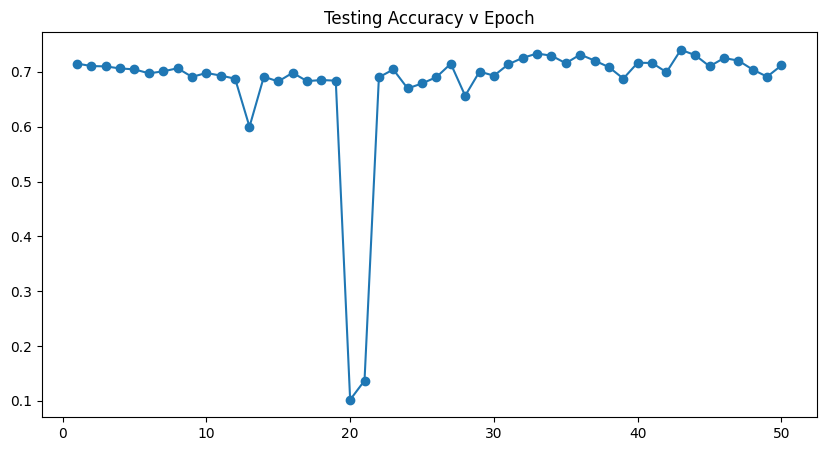

In [22]:
plt.figure(figsize=(10,5))
plt.title("Testing Accuracy v Epoch")
plt.plot(epochs_arr, train_accuracy, marker='o', linestyle='-')
plt.show()

In [23]:

# Evaluation on the test data
model.load_state_dict(torch.load('best_model_highest_accuracy.pth'))
model.eval()
correct = 0
total = 0
test_predictions = []
test_true_labels = []
class_correct = [0 for _ in range(output_size)]
class_total = [0 for _ in range(output_size)]
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        outputs = model(batch_features)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
        test_predictions.extend(predicted.cpu().numpy())
        test_true_labels.extend(batch_labels.cpu().numpy())

        # For per class accuracy
        c = (predicted == batch_labels).squeeze()
        for i in range(len(batch_labels)):
            label = batch_labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


In [24]:
# Per class accuracy
for i in range(output_size):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'Accuracy for class {label_encoder.classes_[i]}: {accuracy:.2f}%')
    else:
        print(f'No samples for class {label_encoder.classes_[i]} in the test set.')


Accuracy for class BENIGN: 73.21%
Accuracy for class Bot: 29.49%
Accuracy for class DDoS: 64.36%
Accuracy for class DoS GoldenEye: 71.03%
Accuracy for class DoS Hulk: 81.34%
Accuracy for class DoS Slowhttptest: 68.36%
Accuracy for class DoS slowloris: 58.77%
Accuracy for class FTP-Patator: 64.67%
Accuracy for class Heartbleed: 0.00%
Accuracy for class Infiltration: 0.00%
Accuracy for class PortScan: 95.91%
Accuracy for class SSH-Patator: 90.84%
Accuracy for class Web Attack � Brute Force: 79.93%
Accuracy for class Web Attack � Sql Injection: 0.00%
Accuracy for class Web Attack � XSS: 0.00%


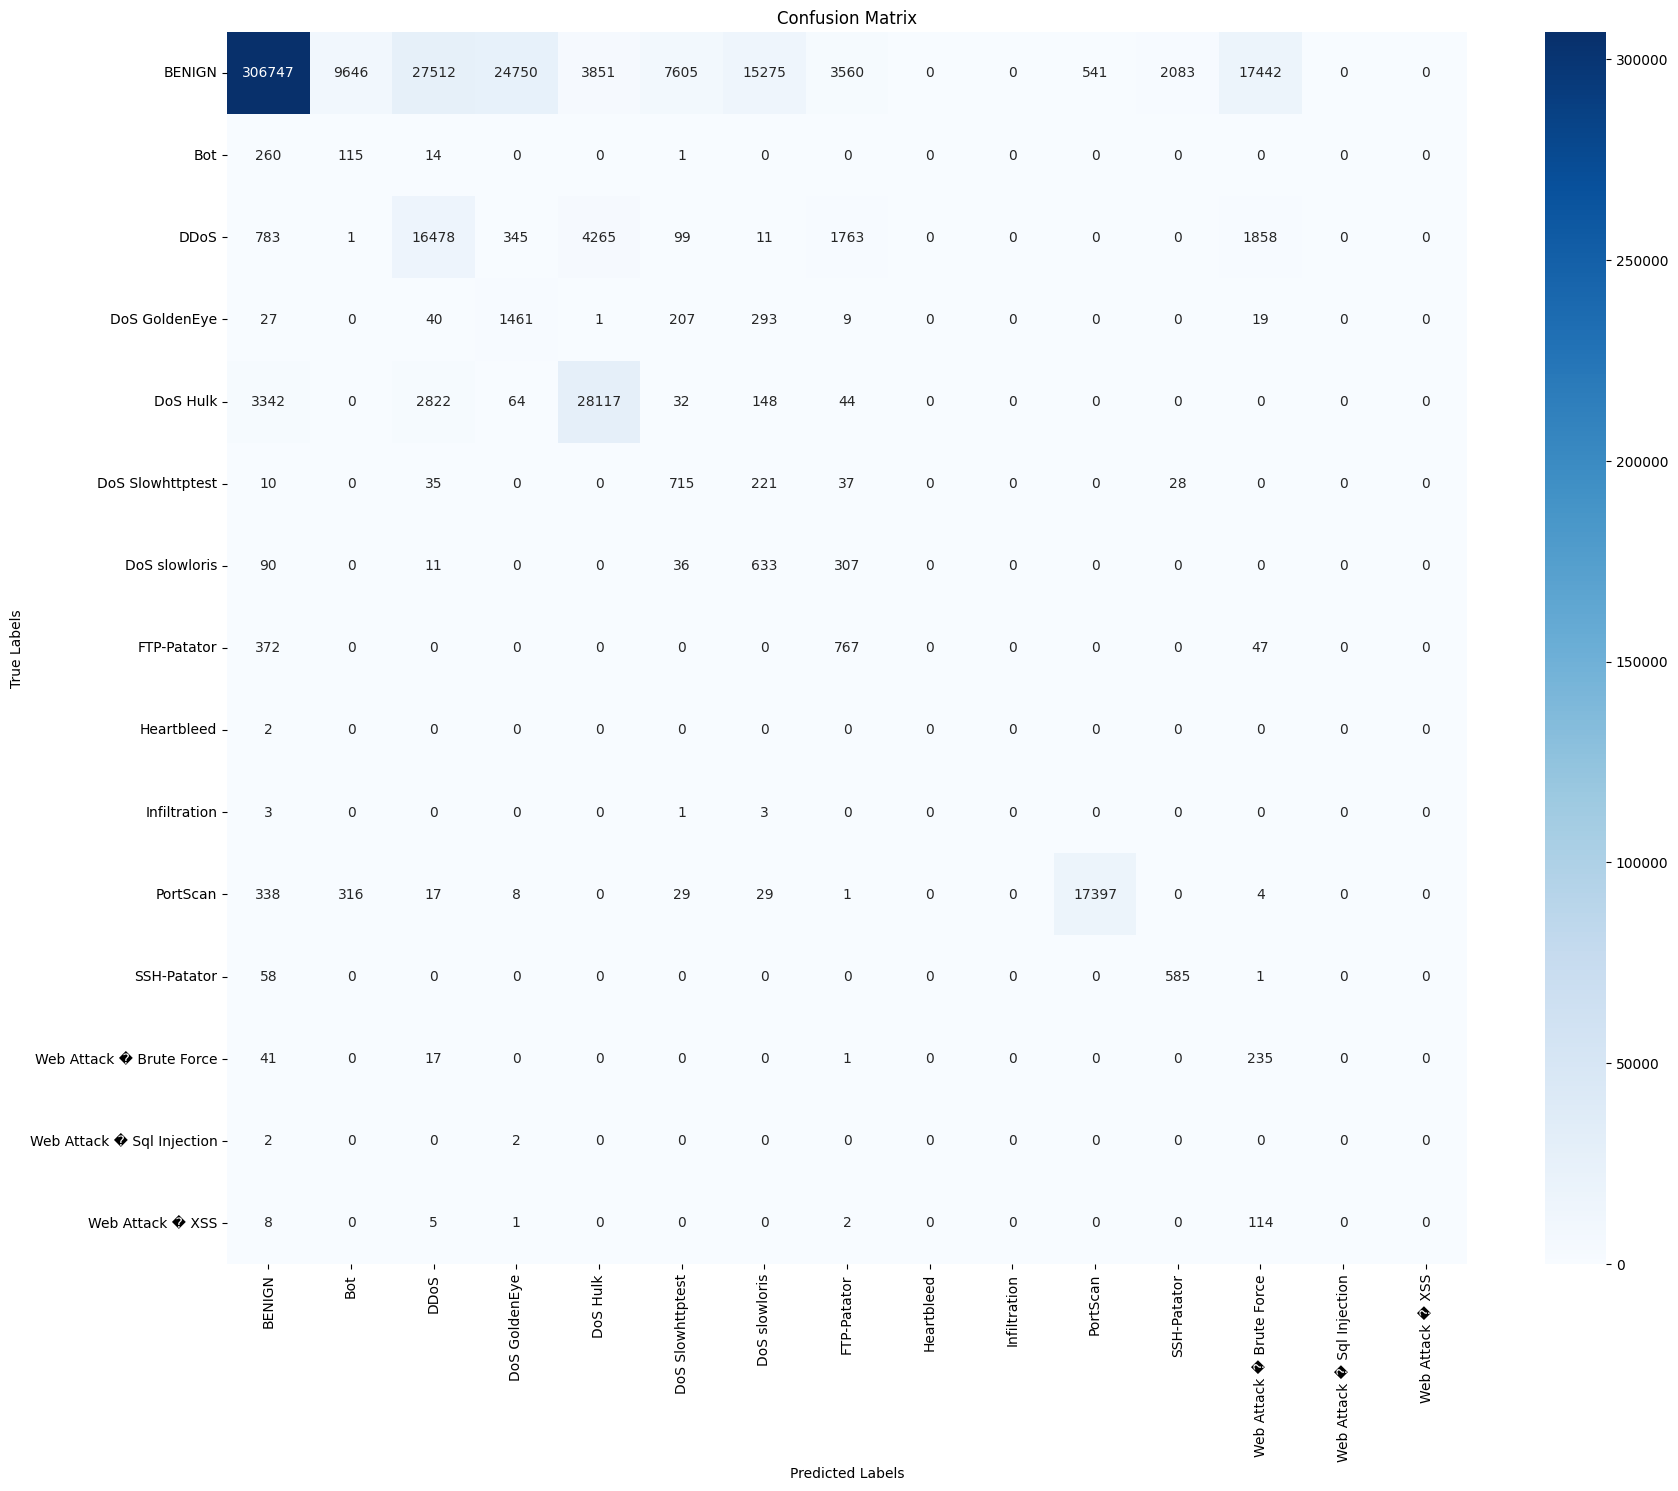

In [25]:

# Confusion matrix
conf_matrix = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [26]:
# Overall performance of the model
accuracy = correct / total
precision = precision_score(test_true_labels, test_predictions, average='weighted')
recall = recall_score(test_true_labels, test_predictions, average='weighted')
f1 = f1_score(test_true_labels, test_predictions, average='weighted')
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 74.03%
Precision: 0.9239
Recall: 0.7403
F1 Score: 0.8115
